In [0]:
#Things to install before running

# !apt install libmpc-dev
# !pip3 install gmpy2

In [0]:
import sys
import os
import cv2
import copy
import gmpy2 as gp
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt, log, floor

In [72]:
print(cv2.__version__)

3.4.3


In [0]:
# Dimensions of input image.
xdimension = 32
ydimension = 32

In [74]:
inp_img = cv2.imread('./InputImages/lena.png', cv2.IMREAD_GRAYSCALE)
inp_img = cv2.resize(inp_img,(xdimension, ydimension), interpolation = cv2.INTER_CUBIC)
print(inp_img)

[[167 162 172 ... 134 135 123]
 [166 163 171 ... 137 109  60]
 [167 171 167 ... 104  65  62]
 ...
 [ 60 165 170 ... 109  99  76]
 [117 173 171 ...  82 117  79]
 [ 64 204 168 ... 108  96  70]]


In [75]:
inp_img=inp_img/1.0
inp_img.shape

(32, 32)

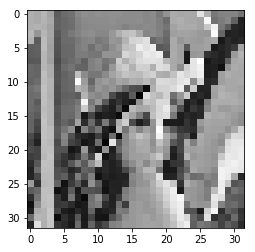

In [76]:
plt.imshow(inp_img, cmap="gray")
plt.show()

In [77]:
# Print images shape and datatype of numpy array representing image.
print(inp_img.shape)
print(inp_img.dtype)

(32, 32)
float64


In [78]:
# Divide 0-255 gray scale range into 10 regions.

max = 255
min = 0
n_range = 10

#length of range
lor = (max - min + 1) / n_range

shades_gray = []

for i in range(1, n_range + 1):
        l1 = []
        start = lor * (i - 1) + min
        end = start + lor - 1
        l1.append(int(start))
        l1.append(int(end + 1))
        shades_gray.append(l1)
shades_gray[9][1]=258

print(shades_gray)

[[0, 25], [25, 51], [51, 76], [76, 102], [102, 128], [128, 153], [153, 179], [179, 204], [204, 230], [230, 258]]


In [0]:
# Dithering filter in Floyd-steinberg dithering
fs_coeffs = [7.0,3.0,5.0,1.0]

In [0]:
class Dither:

    def __init__(self,pixels,xl,yl):

        self.pixels = pixels
        
        self.xl = xl
        self.yl = yl

        self.fs_dither()

    # Given a pixel, it finds to which region from the 10 regions
    # above the pixel belongs, and returns the first element of
    # that range. 

    def _find_closest_palette_color(self, oldpixel): 
        for i in range(0, len(shades_gray)):
            if (oldpixel >= shades_gray[i][0]) and (oldpixel <= shades_gray[i][1]):
                return shades_gray[i][0]

        # This is for case, when a pixel value exceeds 255, when noise is added.
        return 255

    # Actual dithering function, which distributes the error to the
    # neighbouring pixels.

    def fs_dither(self):

        A,B,G,S = map(lambda x : float(x)/16.0, fs_coeffs)

        for y in range(0, self.yl):
            for x in range(0, self.xl):
                oldpixel = self.pixels[x][y]
                newpixel = self._find_closest_palette_color(oldpixel)
                self.pixels[x][y] = float(newpixel)
                quant_error = float(oldpixel - newpixel)
                if (x < self.xl - 1):
                    self.pixels[x+1][y] += (A * quant_error)
                if (x > 0) and (y < self.yl - 1):
                    self.pixels[x-1][y+1] += (B * quant_error)
                if (y < self.yl - 1):
                    self.pixels[x][y+1] += (G * quant_error)
                if (x < self.xl - 1) and (y < self.yl - 1):
                    self.pixels[x+1][y+1] += (S * quant_error) 

In [0]:
class ImgHelper:
    
    def __init__(self, pixels, xl, yl):
        
        self.pixels = pixels
        self.xl = xl
        self.yl = yl
        self.imgstr = ""
        
        self.imgtostr()
        
    # Given an pixel value, it returns to which of the
    # 10 regions the pixel belongs to. 

    # Return value between 0-9 (both inclusive)
    def get_color_index(self, oldpixel):
        for i in range(0, len(shades_gray)):
            if oldpixel == shades_gray[i][0]:
                return i
        
        # Default case: We don't get here though!
        return 9

    # Given an image where pixels belong to only 10 regions,
    # it maps them to the index of the divided regions above (in shades_gray),
    # and adds each pixel's corresponding region to string and returns the 
    # string.

    # Ex: say there are 4 pixels
    #  +-----+-----+
    #  +  0  + 179 +
    #  +-----+-----+
    #  +  51 + 153 +
    #  +-----+-----+


    #  First pixel 0 belongs to 1st element (i.e 0 index) of shades gray list 
    #  Second pixel 179 belongs to 8th element (i.e 7 index) of shades gray list
    #  Third pixel 51 belongs to 3rd element (i.e 2 index) of shades gray list
    #  Fourth pixel 153 belongs to 7th element (i.e 6 index) of shades gray list 

    # The string returned would be "0726".  
    def imgtostr(self):
        
        for y in range(0, self.yl):
            for x in range(0, self.xl):
                self.imgstr += str(self.get_color_index(self.pixels[x][y]))
                
    def get_str(self):
        return self.imgstr
                   

In [0]:
# Function to add subtle noise to image, this noise should
# added before dithering.
def add_noise(img):
        
    r_noise = [-1, 1]
        
    (xl, yl) = img.shape

    for y in range(0, yl):
        for x in range(0, xl):
            oldpixel = img[x][y]
                
            # Randomly add +/- 1% noise to each pixel.
            noise_ind = np.random.randint(low=0, high=2)
            noise_val = r_noise[noise_ind] * oldpixel / 100
                
            img[x][y] = oldpixel + noise_val
    return img

In [0]:
(xl, yl) = inp_img.shape

In [84]:
l2 = copy.deepcopy(inp_img)

# Number of iterations, after which
# we can expect a prime number.

# Check paper for more information.
iters = floor(log(10) * xl * yl * 10)

for i in range(0, iters * 10):
    print("Iteration: " + str(i))
    l2_temp = copy.deepcopy(l2)

    D = Dither(l2_temp, xl, yl)
    I = ImgHelper(l2_temp, xl, yl)
    img_val = int(I.get_str())
    if gp.is_prime(img_val):
        print("Wohoo!")
        break
    l2 = add_noise(l2)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [85]:
gp.is_prime(img_val)

True

In [86]:
print(img_val)

6349442422233345344422522543055199723228586487544323212533975996965696858752964645999764779797538535477647485965529984993946789553264472754129943535224251371224744546435165296344223142522142134422439345733628445942322445423153463326449949535247218445211122888572356486899218233435342313334342234942359955552466528544462115599436938996367414364313323232947753248349844321429131131221139941452628482313503912142442122649774733949474319815523221224762636648868868222647479752216934646558654497911244495543914457356949246359969957452384866675722349434884769999799349787587412458854485749979885949983549996978275994643464569627898999997869739399944533793799879938996612397975938947699896968354144733214969854777758457798982313323216183198899874753226694911212225642479543565642554999962923223988699933831996675586999611215296597794183523364983522342239679983475832664811999622143256441369564833939383738742421336564234546797574676325989252218999886794528968953945238434424989997344999584975464333221123637

In [87]:
# Construct image from prime number.

# Reference image for size
prime_potrait = copy.deepcopy(inp_img)

(xl, yl) = prime_potrait.shape

# 'count' variable to keep track of index of the prime number string
count = 0

print("string length is: " + str(len(str(img_val))))

for y in range(0, yl):
    for x in range(0, xl):
        prime_potrait[x][y] = shades_gray[int(str(img_val)[count])][0]
        count += 1

string length is: 1024


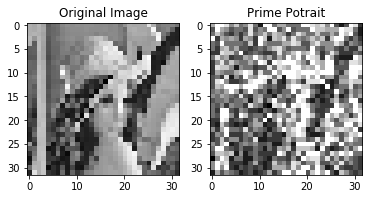

In [88]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(inp_img, cmap="gray")
plt.title("Original Image")
f.add_subplot(1,2, 2)
plt.imshow(prime_potrait, cmap="gray")
plt.title("Prime Potrait")
plt.show(block=True)